In [1]:
from pprint import pprint
import math
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy
from scipy import ndimage
import tensorflow as tf
import keras
from tensorflow.python.framework import ops
#from cnn_utils import *
import os
os.environ['CUDA_VISIBLE_DEVICES']='-1'
import deepdish.io as io
from keras.models import Sequential, Model
from keras.layers import Input, Add, Dense, Dropout, LeakyReLU
from keras.callbacks import ModelCheckpoint
from keras.wrappers.scikit_learn import KerasRegressor
from keras.utils import multi_gpu_model
from sklearn.model_selection import cross_val_score, cross_val_predict, train_test_split
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

/home/debo/env2/local/lib/python2.7/site-packages/h5py/__init__.py:36: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from ._conv import register_converters as _register_converters
/home/debo/env2/local/lib/python2.7/site-packages/h5py/__init__.py:45: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from . import h5a, h5d, h5ds, h5f, h5fd, h5g, h5r, h5s, h5t, h5p, h5z
/home/debo/env2/local/lib/python2.7/site-packages/h5py/_hl/group.py:22: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from .. import h5g, h5i, h5o, h5r, h5t, h5l, h5p
/home/debo/env2/local/lib/python2.7/site-packages/scipy/linalg/basic.py:17: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from ._solve_toeplitz import levinson
/home/debo/env2/local/lib/python2.7/site-packages/scipy/linalg/__init__.py:207: Runtim

In [2]:
#Loading and separating the data
seed = 7
np.random.seed(seed)
X = io.load(os.path.join('Samples_X-0438_ordered.h5'))
target = io.load(os.path.join('Samples_target-0438_ordered.h5'))
truth = io.load(os.path.join('Samples_y-0438_ordered.h5'))
print np.shape(X)
print np.shape(target)
print np.shape(truth)

X = np.reshape(X, (((np.shape(X))[0])*((np.shape(X))[1]),-1))
target = np.reshape(target, (((np.shape(target))[0])*((np.shape(target))[1]),-1))
truth = np.reshape(truth, (((np.shape(truth))[0])*((np.shape(truth))[1]),-1))
print np.shape(X)
print np.shape(target)
print np.shape(truth)

X_train, X_test, truth_train, truth_test, target_train, target_test = train_test_split(
    X, truth, target, test_size=0.25, random_state=seed)

print np.shape(X_train)
print np.shape(truth_train)
print np.shape(X_test)
print np.shape(truth_test)


(3, 1000, 32)
(3, 1000)
(3, 1000)
(3000, 32)
(3000, 1)
(3000, 1)
(2250, 32)
(2250, 1)
(750, 32)
(750, 1)


In [25]:
#Defining Sequential Model
def sequential_model():
    seqModel = Sequential()
    seqModel.add(Dense(32, input_dim=32, kernel_initializer='glorot_normal', activation='relu'))
    seqModel.add(Dense(12, kernel_initializer='glorot_normal', activation='relu'))
    seqModel.add(Dense(1, kernel_initializer='glorot_normal'))

    seqModel.compile(loss='mean_squared_error', optimizer='adam')
    return seqModel

In [98]:
#Calling Sequential Model
estimators = []
estimators.append(('standardize', StandardScaler()))
estimators.append(('mlp', KerasRegressor(build_fn=sequential_model, epochs=50, batch_size=5, verbose=0)))
pipeline1 = Pipeline(estimators)
train=pipeline1.fit(X_train,target_train)
seqResult = pipeline1.predict(X_test)
print("Standardized: %.2f (%.2f) MSE" % (seqResult.mean(), seqResult.std()))
print np.shape(seqResult), np.max(seqResult), np.min(seqResult)

Standardized: -72.26 (6.75) MSE
(750,) -46.606716 -97.150566


In [53]:
#X.shape
#X[0]
#X[0,0:8]

In [3]:
##Defining Res_Net model
#def resnet_model(input_dim, output_dim, target):
def resnet_model(input_dim, output_dim):
    def _build_residual_block(x, apply_first=lambda x: x, apply_last=lambda x: x):
        indim = 40
        skip = apply_first(x)
        h = Dense(60)(x)
        h = Dropout(0.5)(LeakyReLU()(h))
        h = Dense(50)(x)
        h = Dropout(0.5)(LeakyReLU()(h))
        h = Dense(indim)(h)
        h = Dropout(0.5)(LeakyReLU()(h))
        h = apply_last(h)
        h = Dense(indim)(h)
        #Add()([X, X_shortcut])

        return LeakyReLU()(Add()([h, skip]))
    x = Input(shape=(input_dim, ))

    h = Dense(40)(x)
    h = Dropout(0.5)(LeakyReLU()(h))

    h = _build_residual_block(h)

    h = Dense(40)(x)
    h = Dropout(0.5)(LeakyReLU()(h))

    h = _build_residual_block(h)
    #h = _build_residual_block(h, apply_last=_build_residual_block)

    h = Dense(output_dim)(h)
    #y = Activation('sigmoid')(h)
    #if target == 'llhs':
    y = h
    #else:
    #y = Activation('sigmoid')(h) # soft and hard target are constrained between 0 and 1

    return Model(x, y)

In [4]:
model = resnet_model(input_dim =32, output_dim=1)
model.compile(loss='mean_squared_error', optimizer='adam')
sc_X = StandardScaler()
X_train1 = sc_X.fit_transform(X_train)
X_test1 = sc_X.fit_transform(X_test)
model.fit(X_train1,target_train, epochs=50, batch_size=5, verbose=0)
res_Result = model.predict(X_test1)
print np.shape(res_Result), np.max(res_Result), np.min(res_Result)

(750, 1) -63.65948 -88.41531


In [5]:
sti=sig_true_i=np.where(truth_test==1)[0]
bti=bkg_true_i=np.where(truth_test==0)[0]

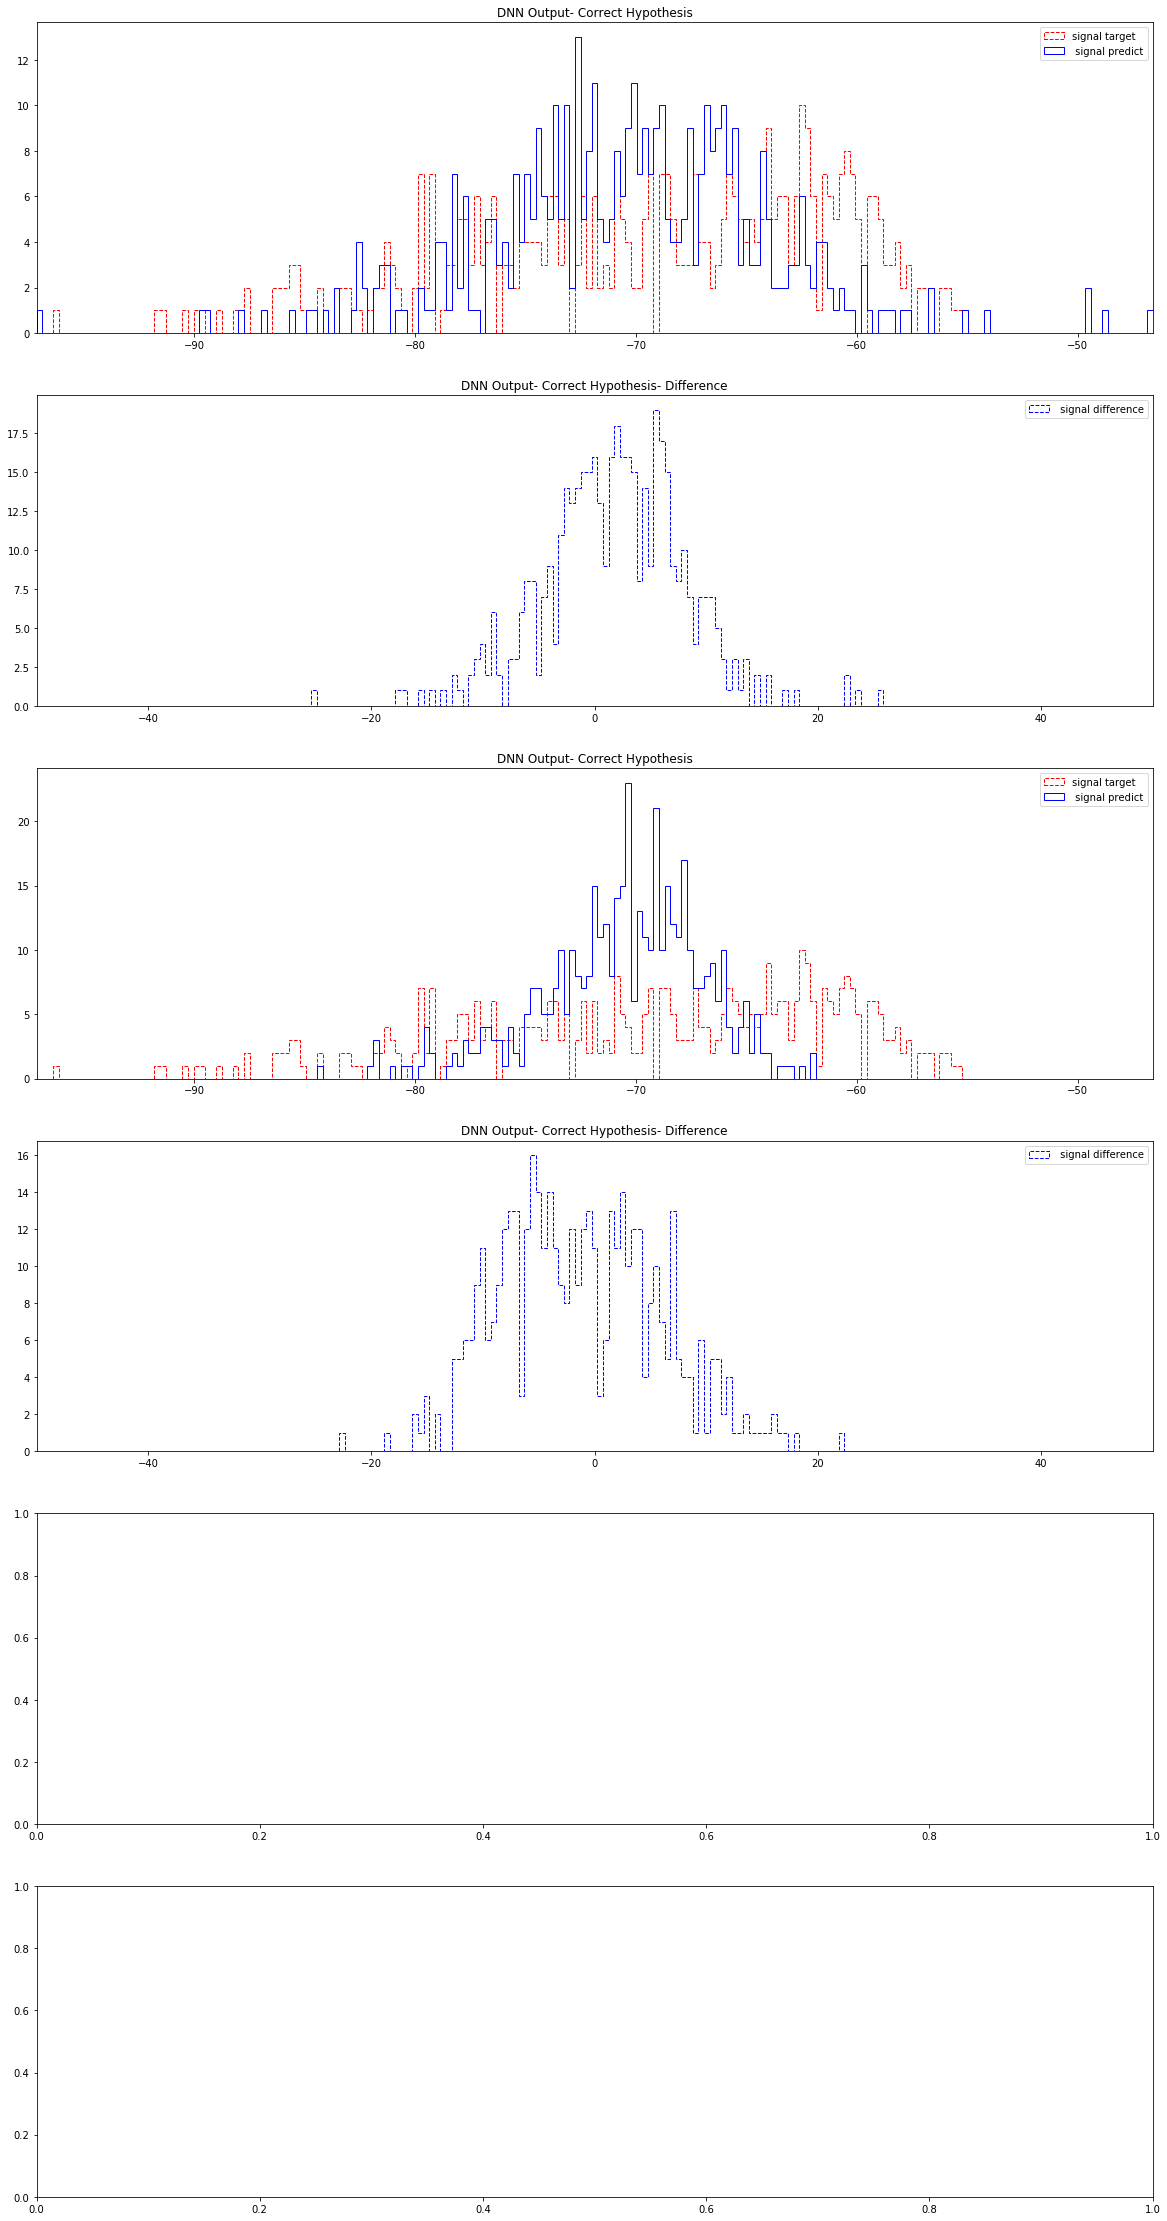

In [109]:
# Compare target to predict DNN output
        # Correct Hypo
n_datasets = 1
n_plots = 6
n_bins = 200
f, axarr = plt.subplots(n_plots, n_datasets, sharex=False,
                            #gridspec_kw = {'height_ratios': [1,1,1,1]},
                            figsize=(20, 40),
                            squeeze=False)
plot_i=0
plot_title="DNN Output- Correct Hypothesis"

min_out=min(target_test.min(),seqResult.min())
max_out=max(target_test.max(),seqResult.max())
bins_out = np.linspace(min_out,max_out,n_bins)
axarr[plot_i,0].set_xlim((min_out,max_out))
        
axarr[plot_i,0].hist(target_test[sti], color='red', histtype='step', bins=bins_out, linestyle='dashed', label='signal target')

#axarr[plot_i,0].hist(target[bti], color='red', histtype='step', bins=bins_out, linestyle='dashed', label=' background target')
axarr[plot_i,0].hist(seqResult[sti], color='blue', histtype='step', bins=bins_out, linestyle='solid', label=' signal predict') 
#axarr[plot_i,0].hist(predict[bti], color='red', histtype='step', bins=bins_out, linestyle='solid', label=' background predict')
        
axarr[plot_i][0].set_title(plot_title)
axarr[plot_i][0].legend(loc='best', ncol=1)

# Plot the Difference 
i=1
plot_i=0
plot_i+=1
plot_title="DNN Output- Correct Hypothesis- Difference"

diff_sig=seqResult[sti]-target_test[sti]
#diff_bkg=predict[bti]-target[bti]
#print diff_sig
#print diff_bkg

min_diff=-50
max_diff=50
bins_diff = np.linspace(min_diff,max_diff,n_bins)

axarr[plot_i,0].set_xlim((min_diff,max_diff))
        
axarr[plot_i,0].hist(diff_sig[0], color='blue', histtype='step', bins=bins_diff, linestyle='dashed', label=' signal difference')
#axarr[plot_i,0].hist(diff_bkg[0], color='red', histtype='step',bins=bins_diff, linestyle='dashed', label=' background difference')
        
axarr[plot_i][0].set_title(plot_title)
axarr[plot_i][0].legend(loc='best', ncol=1)

#Res_Net model
plot_i+=1
plot_title="DNN Output- Correct Hypothesis"

#min_out=min(target_test.min(),res_Result.min())
#max_out=max(target_test.max(),res_Result.max())
#bins_out = np.linspace(min_out,max_out,n_bins)
axarr[plot_i,0].set_xlim((min_out,max_out))
        
axarr[plot_i,0].hist(target_test[sti], color='red', histtype='step', bins=bins_out, linestyle='dashed', label='signal target')

#axarr[plot_i,0].hist(target[bti], color='red', histtype='step', bins=bins_out, linestyle='dashed', label=' background target')
axarr[plot_i,0].hist(res_Result[sti], color='blue', histtype='step', bins=bins_out, linestyle='solid', label=' signal predict') 
#axarr[plot_i,0].hist(predict[bti], color='red', histtype='step', bins=bins_out, linestyle='solid', label=' background predict')
        
axarr[plot_i][0].set_title(plot_title)
axarr[plot_i][0].legend(loc='best', ncol=1)

# Plot the Difference 
plot_i+=1
plot_title="DNN Output- Correct Hypothesis- Difference"

resDiff_sig=res_Result[sti]-target_test[sti]
#diff_bkg=predict[bti]-target[bti]
#print diff_sig
#print diff_bkg

min_diff1=-50
max_diff1=50
bins_diff1 = np.linspace(min_diff1,max_diff1,200)

axarr[plot_i,0].set_xlim((min_diff1,max_diff1))
        
axarr[plot_i,0].hist(resDiff_sig, color='blue',histtype='step', bins=bins_diff1, linestyle='dashed', label=' signal difference')
#axarr[plot_i,0].hist(diff_bkg[0], color='red', histtype='step',bins=bins_diff, linestyle='dashed', label=' background difference')
        
axarr[plot_i][0].set_title(plot_title)
axarr[plot_i][0].legend(loc='best', ncol=1)

In [73]:
resDiff_sig=res_Result[sti]-target_test[sti]

In [74]:
print np.shape(resDiff_sig), np.max(resDiff_sig), np.min(resDiff_sig)

(446, 1) 20.17019323493126 -23.036738642831864


In [77]:
print("Standardized: %.2f (%.2f) MSE" % (resDiff_sig.mean(), resDiff_sig.std()))

Standardized: -2.91 (7.08) MSE


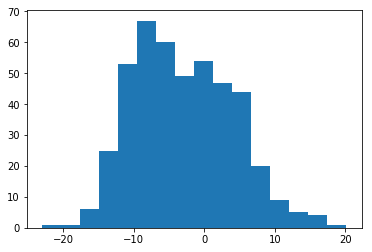

In [78]:
plt.hist(resDiff_sig, bins='auto')
plt.show()

In [2]:
data_A = io.load(os.path.join('MEM-A-0500_unscaled_signal.h5'))
data_B = io.load(os.path.join('MEM-B-0500_unscaled_signal.h5'))
data_C = io.load(os.path.join('MEM-C-0500_unscaled_signal.h5'))

In [3]:
print(data_C.keys())

['y', 'X', 'signal_llh']


In [4]:
X_Big_train = data_A['X']
target_Big_train = data_A['signal_llh']
y_Big_train = data_A['y']

X_Big_test = data_B['X']
target_Big_test = data_B['signal_llh']
y_Big_test = data_B['y']

X_Big_valid = data_C['X']
target_Big_valid = data_C['signal_llh']
y_Big_valid = data_C['y']

np.shape(y_Big_valid)

(858213,)

In [69]:
X_Big_train[0,:]

array([ 1.60053482e+02,  3.76157722e+01,  4.59020767e+01,  7.24027176e+01,
        7.05109100e+01,  1.05436775e+02,  3.29363976e+01,  1.24970154e+02,
        2.30744839e+00, -1.61757755e+00, -1.95439517e-01,  8.95875216e-01,
        2.47034168e+00,  2.29786325e+00,  4.11413014e-01, -2.68603772e-01,
       -2.50591546e-01, -2.64650035e+00, -1.11038613e+00,  2.85890651e+00,
        7.24493384e-01, -2.63377279e-01, -2.83341169e+00,  2.37839603e+00,
        8.12146274e+02,  9.86511089e+01,  4.70170272e+01,  1.03560374e+02,
        4.19929242e+02,  5.29997252e+02,  3.57633551e+01,  1.29505496e+02])

In [70]:
X_Big_train[0,0:8]

array([160.05348206,  37.61577225,  45.90207672,  72.40271759,
        70.51091003, 105.43677521,  32.93639755, 124.97015381])

In [71]:
X_pT = X_Big_train[:,0:8]

In [72]:
np.shape(X_pT)

(3028985, 8)

In [73]:
H_T = np.sum(X_pT,axis=1)

In [74]:
np.shape(H_T)

(3028985,)

In [75]:
H_T[0]

649.8282852172852

In [80]:
print np.shape(H_T), np.max(H_T), np.min(H_T)
print("Standardized: %.2f (%.2f) MSE" % (H_T.mean(), H_T.std()))

(3028985,) 5573.933792114258 210.0051612854004
Standardized: 608.93 (197.31) MSE


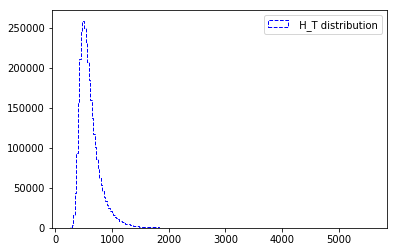

<Figure size 1440x5760 with 0 Axes>

In [85]:
n_bins = 200
min_ht = np.min(H_T)
max_ht = np.max(H_T)
bins_ht = np.linspace(min_ht,max_ht,n_bins)
plt.hist(H_T, color='blue',histtype='step', bins=bins_ht, linestyle='dashed', label=' H_T distribution')
plt.legend(loc='best', ncol=1)
plt.figure(figsize=(20,80))
plt.show()

In [98]:
estimators = []
estimators.append(('standardize', StandardScaler()))
estimators.append(('mlp', KerasRegressor(build_fn=sequential_model, epochs=50, batch_size=5, verbose=1)))
pipeline1 = Pipeline(estimators)
train=pipeline1.fit(X_Big_train,target_Big_train)

Instructions for updating:
keep_dims is deprecated, use keepdims instead
Epoch 1/50
 334370/3028985 [==>...........................] - ETA: 791s - loss: 59.8772

KeyboardInterrupt: 

In [12]:
def sequential_model():
    seqModel = Sequential()
    seqModel.add(Dense(32, input_dim=32, kernel_initializer='glorot_normal', activation='relu'))
    seqModel.add(Dense(12, kernel_initializer='glorot_normal', activation='relu'))
    seqModel.add(Dense(1, kernel_initializer='glorot_normal'))
    
    #seqModel = make_parallel(seqModel, 4)
    #seqModel = multi_gpu_model(seqModel, gpus=2)
    seqModel.compile(loss='mean_squared_error', optimizer='adam')
    return seqModel

In [100]:
estimators = []
estimators.append(('standardize', StandardScaler()))
estimators.append(('mlp', KerasRegressor(build_fn=sequential_model, epochs=50, batch_size=2048*4, verbose=1)))
pipeline1 = Pipeline(estimators)
train=pipeline1.fit(X_Big_train,target_Big_train)

NameError: global name 'make_parallel' is not defined

In [26]:
#model = sequential_model()
#model.fit(X_Big_train,target_Big_train, epochs=20, batch_size=256)
#Calling Sequential Model
estimators = []
estimators.append(('standardize', StandardScaler()))
estimators.append(('mlp', KerasRegressor(build_fn=sequential_model, epochs=20, batch_size=256, verbose=1)))
pipeline1 = Pipeline(estimators)
train=pipeline1.fit(X_Big_train,target_Big_train)
seqResult = pipeline1.predict(X_Big_test)
print("Standardized: %.2f (%.2f) MSE" % (seqResult.mean(), seqResult.std()))
print np.shape(seqResult), np.max(seqResult), np.min(seqResult)

Epoch 1/20
3028985/3028985 [==============================] - 19s 6us/step - loss: 120.6315
Epoch 2/20
3028985/3028985 [==============================] - 18s 6us/step - loss: 31.1745
Epoch 3/20
3028985/3028985 [==============================] - 18s 6us/step - loss: 29.2120
Epoch 4/20
3028985/3028985 [==============================] - 18s 6us/step - loss: 28.1366
Epoch 5/20
3028985/3028985 [==============================] - 18s 6us/step - loss: 27.6101
Epoch 6/20
3028985/3028985 [==============================] - 18s 6us/step - loss: 27.2775
Epoch 7/20
3028985/3028985 [==============================] - 18s 6us/step - loss: 27.0021
Epoch 8/20
3028985/3028985 [==============================] - 18s 6us/step - loss: 26.7678
Epoch 9/20
3028985/3028985 [==============================] - 18s 6us/step - loss: 26.5912
Epoch 10/20
3028985/3028985 [==============================] - 18s 6us/step - loss: 26.3881
Epoch 11/20
3028985/3028985 [==============================] - 18s 6us/step - loss: 26.2

In [19]:
Result = model.predict(X_Big_test)

In [20]:
print np.shape(Result), np.max(Result), np.min(Result)

(151449, 1) -48.57271 -108.2321


In [27]:
sti=sig_true_i=np.where(y_Big_test==1)[0]
bti=bkg_true_i=np.where(y_Big_test==0)[0]

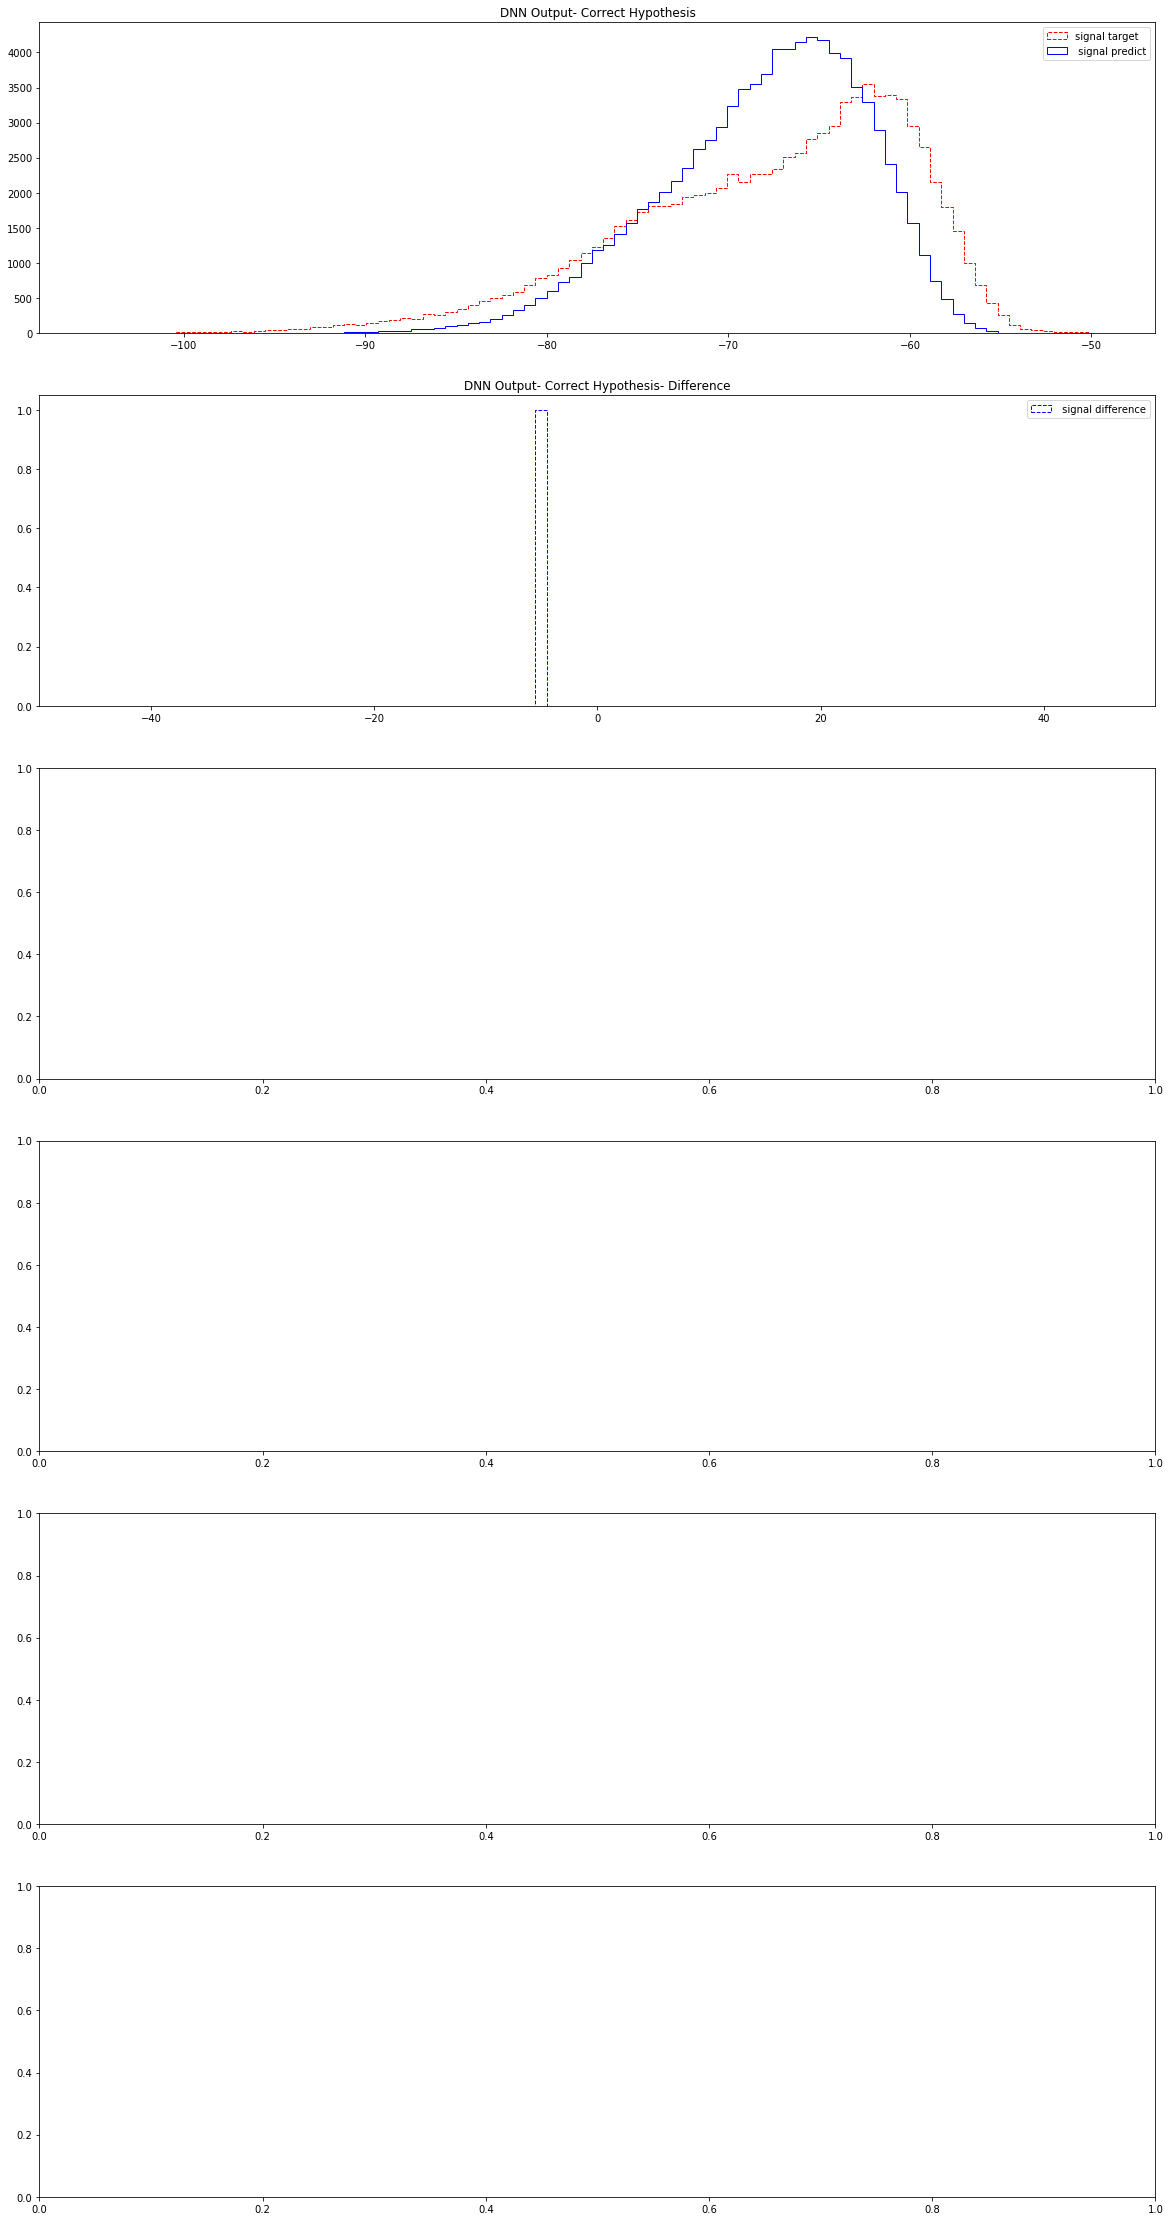

In [32]:
n_datasets = 1
n_plots = 6
n_bins = 100
f, axarr = plt.subplots(n_plots, n_datasets, sharex=False,
                            #gridspec_kw = {'height_ratios': [1,1,1,1]},
                            figsize=(20, 40),
                            squeeze=False)
plot_i=0
plot_title="DNN Output- Correct Hypothesis"

min_out=min(target_Big_test.min(),seqResult.min())
max_out=max(target_Big_test.max(),seqResult.max())
bins_out = np.linspace(min_out,max_out,n_bins)
axarr[plot_i,0].set_xlim((min_out,max_out))
        
axarr[plot_i,0].hist(target_Big_test[sti], color='red', histtype='step', bins=bins_out, linestyle='dashed', label='signal target')

#axarr[plot_i,0].hist(target[bti], color='red', histtype='step', bins=bins_out, linestyle='dashed', label=' background target')
axarr[plot_i,0].hist(seqResult[sti], color='blue', histtype='step', bins=bins_out, linestyle='solid', label=' signal predict') 
#axarr[plot_i,0].hist(predict[bti], color='red', histtype='step', bins=bins_out, linestyle='solid', label=' background predict')
        
axarr[plot_i][0].set_title(plot_title)
axarr[plot_i][0].legend(loc='best', ncol=1)

# Plot the Difference 
i=1
plot_i=0
plot_i+=1
plot_title="DNN Output- Correct Hypothesis- Difference"

diff_sig=seqResult[sti]-target_Big_test[sti]
#diff_bkg=predict[bti]-target[bti]
#print diff_sig
#print diff_bkg

min_diff=-50
max_diff=50
bins_diff = np.linspace(min_diff,max_diff,n_bins)

axarr[plot_i,0].set_xlim((min_diff,max_diff))
        
axarr[plot_i,0].hist(diff_sig[0], color='blue', histtype='step', bins=bins_diff, linestyle='dashed', label=' signal difference')
#axarr[plot_i,0].hist(diff_bkg[0], color='red', histtype='step',bins=bins_diff, linestyle='dashed', label=' background difference')
        
axarr[plot_i][0].set_title(plot_title)
axarr[plot_i][0].legend(loc='best', ncol=1)

In [35]:
model = resnet_model(input_dim =32, output_dim=1)
model.compile(loss='mean_squared_error', optimizer='adam')
sc_X = StandardScaler()
X_train1 = sc_X.fit_transform(X_Big_train)
X_test1 = sc_X.fit_transform(X_Big_test)
model.fit(X_train1,target_Big_train, epochs=20, batch_size=256, verbose=1)
res_Result = model.predict(X_test1)
print np.shape(res_Result), np.max(res_Result), np.min(res_Result)

Epoch 1/20
3028985/3028985 [==============================] - 38s 12us/step - loss: 126.6343
Epoch 2/20
3028985/3028985 [==============================] - 39s 13us/step - loss: 37.7002
Epoch 3/20
3028985/3028985 [==============================] - 38s 13us/step - loss: 35.6584
Epoch 4/20
3028985/3028985 [==============================] - 39s 13us/step - loss: 35.2304
Epoch 5/20
3028985/3028985 [==============================] - 39s 13us/step - loss: 34.9017
Epoch 6/20
3028985/3028985 [==============================] - 39s 13us/step - loss: 34.7275
Epoch 7/20
3028985/3028985 [==============================] - 38s 13us/step - loss: 34.6018
Epoch 8/20
3028985/3028985 [==============================] - 38s 13us/step - loss: 34.4968
Epoch 9/20
3028985/3028985 [==============================] - 39s 13us/step - loss: 34.4258
Epoch 10/20
3028985/3028985 [==============================] - 39s 13us/step - loss: 34.3595
Epoch 11/20
3028985/3028985 [==============================] - 39s 13us/step -

In [ ]:
n_datasets = 1
n_plots = 6
n_bins = 100
f, axarr = plt.subplots(n_plots, n_datasets, sharex=False,
                            #gridspec_kw = {'height_ratios': [1,1,1,1]},
                            figsize=(20, 40),
                            squeeze=False)
plot_i=0
plot_title="DNN Output- Correct Hypothesis"

min_out=min(target_Big_test.min(),seqResult.min())
max_out=max(target_Big_test.max(),seqResult.max())
bins_out = np.linspace(min_out,max_out,n_bins)
axarr[plot_i,0].set_xlim((min_out,max_out))
        
axarr[plot_i,0].hist(target_Big_test[sti], color='red', histtype='step', bins=bins_out, linestyle='dashed', label='signal target')

#axarr[plot_i,0].hist(target[bti], color='red', histtype='step', bins=bins_out, linestyle='dashed', label=' background target')
axarr[plot_i,0].hist(seqResult[sti], color='blue', histtype='step', bins=bins_out, linestyle='solid', label=' signal predict') 
#axarr[plot_i,0].hist(predict[bti], color='red', histtype='step', bins=bins_out, linestyle='solid', label=' background predict')
        
axarr[plot_i][0].set_title(plot_title)
axarr[plot_i][0].legend(loc='best', ncol=1)